The goal of this tutorial is to use Pytorch to train a Deep Q Learning(DQN) agent on the `CartPole-v0` task from the OpenAI Gym.

# Import packages

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T

In [3]:
env = gym.make("CartPole-v0").unwrapped

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/Users/qianqu/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


# Replay Memory

Experience replay will help us to handle two things:
* Avoid forgetting previous experiences.
* Reduce correlations between experiences.



We need to classes:

* `Transition` - a tuple representing a single transition in our environment. It maps (state, action) pairs to their (next_state, reward)
* `ReplayMemory` - a cyclic buffer of bounded size that holds the transitions observed recently. It also implement a `.sample()` method for selecting a random batch of transitions for training.

In [4]:
Transition = namedtuple('Transition',
                       ('state', 'action', 'next_state', 'reward'))

In [5]:
class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        """Save a transition"""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = Transition(*args)
        self.position = (self.position+1) % self.capacity
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)
    
    

# Q-network

Our Q-network would be a convolutional neural network that takes in the difference between the current and previous screen patches. 

In [6]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        
        self.conv1 = nn.Conv2d(3,16,kernel_size=5,stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,kernel_size=5,stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,32,kernel_size=5,stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        
        def conv2d_size_out(size, kernel_size=5, stride=2):
            # calculate the output size of convolutional layer
            return (size - kernel_size) // stride + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_size = convw * convh * 32
        
        self.head = nn.Linear(linear_size, outputs)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        out = self.head(x.view(x.size(0),-1)) # x.size(0) is batch size
        return out

# Input extraction


It use `torchvision.transform` to compose image

get_cart_location:  594
scale 250.0
screen_width 1200


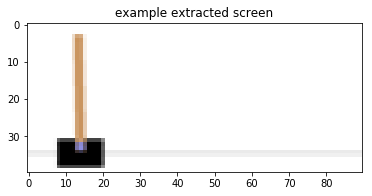

In [9]:
# first resize
resize = T.Compose([T.ToPILImage(),
                   T.Resize(40, interpolation=Image.CUBIC),
                   T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return_val = int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART
    #print("get_cart_location: ", return_val)
    #print("scale", scale)
    #print("screen_width", screen_width)
    return return_val

def get_screen():
    # return screen requested by gym is 400*600*3
    
    # first change to torch order channel*height*width
    screen = env.render(mode="rgb_array").transpose((2, 0 ,1))
    _, screen_height, screen_width = screen.shape
    # in cartpole-v0, we can cut off the top and bottom of the screen
    screen = screen[:, int(screen_height*0.4):int(screen_height*0.8)]
    # now cut width
    view_width = int(screen_width*0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width//2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width)//2:
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width//2,
                           cart_location + view_width//2)
    screen = screen[:, :, slice_range]
    
    # conver to float, rescale to 0-1, to tensor, to device
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    screen = resize(screen).unsqueeze(0).to(device)
    
    return screen

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1,2,0).numpy(),
          interpolation='none')
plt.title('example extracted screen')
plt.show()
env.close()

In [8]:
env.state

array([-0.02870912,  0.00937056, -0.03623778,  0.0379286 ])